In [52]:
import os
import sys

In [53]:
#sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [54]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [55]:
np.set_printoptions(linewidth=500)

In [60]:
c2p = Cell2PointsConverter(orders=[[5],[5,5]])

In [61]:
c2p.weights[0][0].sum()

0.99999999999999989

In [62]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [65]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(risky=2), method='svd', options={'eps':1e-6})

Number of equations: 85
Number of degrees of freedom: 66
Strictly stitched_power: 4
Start solving strict part
[False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True  True  True  True  True  True]
Nullspace shape: (66, 6)
End solving strict part
NullspaceRank: 6


In [66]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()
#interps, wgths

In [81]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(risky=2),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [ ]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=2)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [69]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [70]:
tr_f = np.vectorize(lambda x: x*(x-1))

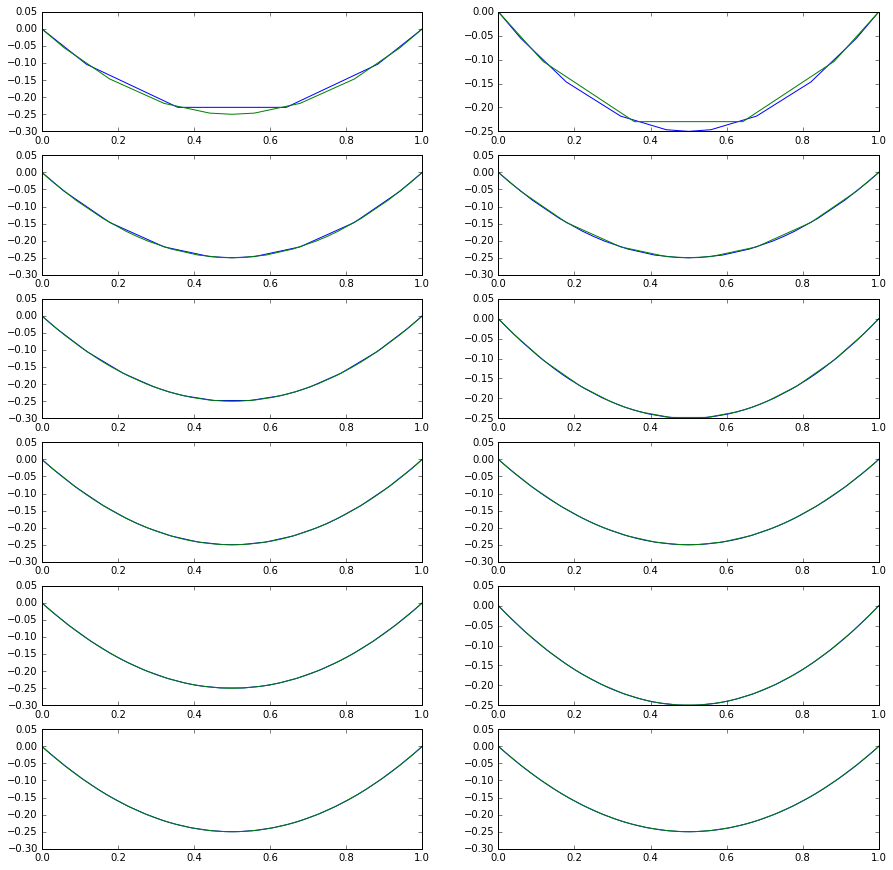

In [74]:
eps_l, eps_r = convergence_test(I_lr=new_int1,
                                I_rl=new_int2,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

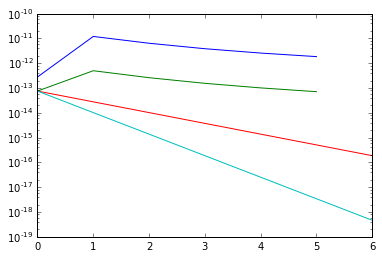

In [47]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [75]:
np.linalg.eigvals(np.dot(new_int2, new_int1))

array([ 2.98008745,  1.00000764,  1.00000626,  1.00000374,  0.99999797,  0.99999749])

In [76]:
np.linalg.eigvals(np.dot(I_rl, I_lr))

array([ 3.10410691 +0.00000000e+00j,  1.00000807 +2.05841655e-05j,  1.00000807 -2.05841655e-05j,  0.99999162 +1.00885609e-05j,  0.99999162 -1.00885609e-05j,  1.00001373 +0.00000000e+00j])

In [72]:
new_int1 = (I_lr + I_lr[::-1,::-1])/2

In [73]:
new_int2 = (I_rl + I_rl[::-1, ::-1])/2

In [77]:
new_int1

array([[ 0.81754162,  0.43473261, -0.5263626 ,  0.5263626 , -0.43473261,  0.18245838],
       [ 0.42887393,  0.56763922,  0.08573385, -0.17818385,  0.17044578, -0.07450393],
       [-0.22878392,  1.10846921,  0.05091138,  0.16763862, -0.17699421,  0.07875892],
       [ 0.08005767, -0.13884084,  1.31121   , -0.449045  ,  0.33237084, -0.13574767],
       [-0.06491343,  0.10570322,  0.50879748,  0.70865252, -0.42450822,  0.16626343],
       [ 0.0625    , -0.194645  ,  0.63215   ,  0.63215   , -0.194645  ,  0.0625    ],
       [ 0.16626343, -0.42450822,  0.70865252,  0.50879748,  0.10570322, -0.06491343],
       [-0.13574767,  0.33237084, -0.449045  ,  1.31121   , -0.13884084,  0.08005767],
       [ 0.07875892, -0.17699421,  0.16763862,  0.05091138,  1.10846921, -0.22878392],
       [-0.07450393,  0.17044578, -0.17818385,  0.08573385,  0.56763922,  0.42887393],
       [ 0.18245838, -0.43473261,  0.5263626 , -0.5263626 ,  0.43473261,  0.81754162]])

In [78]:
new_int2

array([[ 0.40878111,  1.21738669, -0.95206492,  0.33314864, -0.18425171,  0.0625    ,  0.47194171, -0.56491364,  0.32774492, -0.21148669,  0.09121889],
       [ 0.0382833 ,  0.28381791,  0.81252745, -0.10177947,  0.05284786, -0.034285  , -0.21225286,  0.24363947, -0.12974245,  0.08522709, -0.0382833 ],
       [-0.03162156,  0.02924139,  0.02546341,  0.65560948,  0.17354209,  0.075955  ,  0.24167791, -0.22452448,  0.08381159, -0.06077139,  0.03162156],
       [ 0.03162156, -0.06077139,  0.08381159, -0.22452448,  0.24167791,  0.075955  ,  0.17354209,  0.65560948,  0.02546341,  0.02924139, -0.03162156],
       [-0.0382833 ,  0.08522709, -0.12974245,  0.24363947, -0.21225286, -0.034285  ,  0.05284786, -0.10177947,  0.81252745,  0.28381791,  0.0382833 ],
       [ 0.09121889, -0.21148669,  0.32774492, -0.56491364,  0.47194171,  0.0625    , -0.18425171,  0.33314864, -0.95206492,  1.21738669,  0.40878111]])

In [ ]:
new_int1 = np.array([[ 1.   ,  0.   ,  0.   ],
       [ 0.375,  0.75 , -0.125],
       [ 0.   ,  1.   ,  0.   ],
       [-0.125,  0.75 ,  0.375],
       [ 0.   ,  0.   ,  1.   ]])



In [ ]:
new_int2 = np.dot(np.dot(c2p.get_diag_weights()[1], new_int1), np.linalg.inv(c2p.get_diag_weights()[0])).T

In [ ]:
new_int1

In [ ]:
new_int2

In [ ]:
new_int1 = normalize((new_int1 + new_int2.T)/2)

In [ ]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1, axis=-1)
    return (v.T/norm).T

In [ ]:
from common.polynom_factory import polynom_factory

def get_href_constrain_matrix(order, inversed=False, distribution='uniform'):
    glob_func_on_loc_mesh = np.zeros((order+1, order+1))
    funcs_prim, glob_grid = polynom_factory(dim=1, order=order,size=(0,2), distribution=distribution)
    funcs, local_grid = polynom_factory(dim=1, order=order,size=(0,1), distribution=distribution)
    for num1, i in enumerate(local_grid):
        for num2, prim_f in enumerate(funcs_prim):
            glob_func_on_loc_mesh[num1, num2] = prim_f.subs({'x_1':i[0]})
    if(inversed):
        return np.linalg.inv(glob_func_on_loc_mesh)
    else:
        return glob_func_on_loc_mesh

In [ ]:
a = get_href_constrain_matrix(distribution='globatto', order=5)
b = np.vstack((a, a[::-1,::-1][1:]))

In [ ]:
a[::-1, ::-1][1:]

In [ ]:
a[1:][::-1, ::-1]

In [ ]:
b

In [ ]:
a

In [ ]:
import sympy

In [ ]:
opt_solve.I_lr.shape

In [ ]:
opt_solve.I_rl.shape

In [ ]:
b.shape

In [ ]:
eq_matrix = opt_solve.I_lr - sympy.Matrix(b)

In [ ]:
eqs_list = []
for i,j in itertools.product(*[range(i) for i in eq_matrix.shape]):
    eqs_list.append(eq_matrix[i,j])

In [ ]:
A,b = sympy.linear_eq_to_matrix(eqs_list, *eq_matrix.free_symbols)

In [ ]:
A_n = np.array(A)
b_n = np.array(b)

In [ ]:
A_n.shape

In [ ]:
b_n.shape

In [ ]:
sol = np.linalg.lstsq(a=A_n, b=b_n)[0]

In [ ]:
subbed = opt_solve.I_lr.subs({i:j for i,j in zip(opt_solve.I_lr.free_symbols, sol)}) 

In [ ]:
subbed

In [ ]:
log = np.linalg.lstsq(a=A_n, b=b_n)

In [ ]:
log

In [ ]:
sol

In [ ]:
a = [8,7,6,5,4,3,2]

In [ ]:
b = "1 2 3 4 5 6 7 8 9".split(" ")

In [ ]:
c = [b[i] for i in a]

In [ ]:
c

In [ ]:
b